# Partial Dependence Plot
Partial dependence for two features

Two-way PDP helps us understand and visualize feature intereactions.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from alibi.explainers import PartialDependence, plot_pd

In [2]:
df = pd.read_csv('filtered_output.csv')
df.drop(['stop_sequence', 'route_id'], axis = 1, inplace = True)
df.head()

,Origin,Destination,0-3,3-6,6-9,9-12,12-15,15-18,18-21,21-24,monday,tuesday,wednesday,thursday,friday,saturday,sunday,delay
0,"Handschuhsheim, Burgstraße","Handschuhsheim, Biethsstraße",0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.0
1,"Handschuhsheim, Burgstraße","Handschuhsheim, Biethsstraße",0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.0
2,"Handschuhsheim, Burgstraße","Handschuhsheim, Biethsstraße",0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.0
3,"Handschuhsheim, Burgstraße","Handschuhsheim, Biethsstraße",0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,NaN
4,"Handschuhsheim, Burgstraße","Handschuhsheim, Biethsstraße",0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0


In [3]:
df = df[df['delay'].notna()]

In [4]:
df.dtypes

Origin          object
Destination     object
0-3              int64
3-6              int64
6-9              int64
9-12             int64
12-15            int64
15-18            int64
18-21            int64
21-24            int64
monday           int64
tuesday          int64
wednesday        int64
thursday         int64
friday           int64
saturday         int64
sunday           int64
delay          float64
dtype: object

In [5]:
# extract feature names
feature_names = df.columns.tolist()
feature_names.remove('delay')

# define target names
target_names = ['delay']

# define categorical columns
categorical_columns_names = ['Origin', 'Destination']

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]

# extract data
X = df[feature_names]
y = df['delay']

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# define and fit the oridnal encoder
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])

# transform the categorical columns to ordinal encoding
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

# convert data to numpy
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# define categorical mappings
categorical_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}

In [7]:
# define numerical standard sclaer
num_transf = StandardScaler()

# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorical_names.values()],
    handle_unknown='ignore',
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)

In [8]:
# fit preprocessor
preprocessor.fit(X_train)

# preprocess train and test datasets
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [9]:
# define and fit regressor - feel free to play with the hyperparameters
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f' % (predictor.score(X_test_ohe, y_test)))

Train score: 0.63
Test score: 0.26


In [10]:
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

In [11]:
# define explainer
explainer = PartialDependence(predictor=prediction_fn,
                              feature_names=feature_names,
                              target_names=target_names,
                              categorical_names=categorical_names)

In [12]:
features = [(feature_names.index('Origin'),feature_names.index('Destination'))]

In [13]:
# compute explanations
exp2 = explainer.explain(X=X_train,
                        features=features,
                        kind='average',
                        grid_resolution=25)

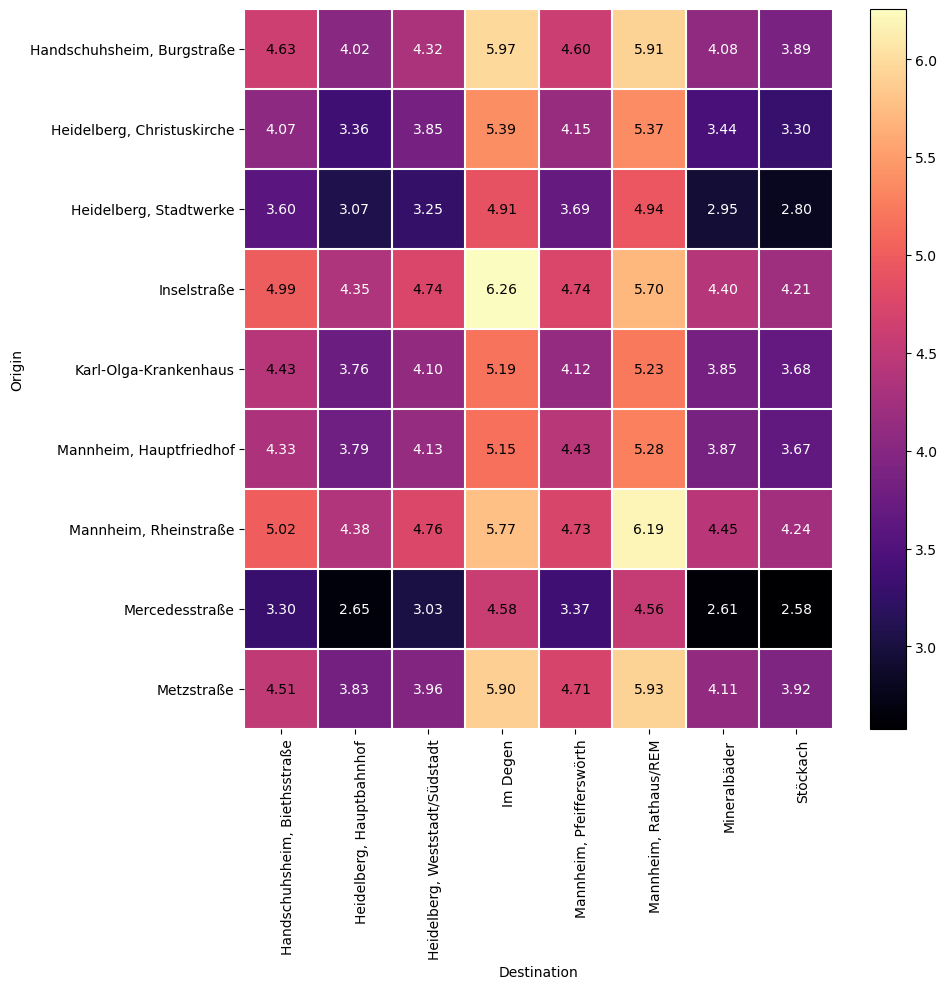

In [14]:
# plot partial dependece curves
plot_pd(exp=exp2,
        n_cols=2,
        fig_kw={'figheight': 10, 'figwidth': 10});